In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate, calibrate_multiple

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol 
    #data.ema_diff.ewm(span=vol_lookback).std()
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    #data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    data[f'ema_{periods}'] = data['ema_diff_norm']
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    #data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 100
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc']
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
def roca(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.diff()
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [10]:
sym = 'NQ'
periods = [5,10,20,40]

In [11]:
s= '20180501'
params = {
    'bolli_reduced': calibrate_multiple(sym, bolli_reduced, start_date=s, periods=periods),
    'ema': calibrate_multiple(sym, ema, start_date=s, periods=periods),
    'breakout': calibrate_multiple(sym, breakout, start_date=s, periods=periods,adjustment=20),
    'carver': calibrate_multiple(sym, carver, start_date=s, periods=periods, adjustment=40),
    'roc': calibrate_multiple(sym, roc, start_date=s, periods=periods),
    'roca': calibrate_multiple(sym, roca, start_date=s, periods=periods),
}

In [12]:
func = ema
data = simulate(params[func.__name__], sym, func,periods=periods)

In [13]:
data.forecast.abs().mean(), data.forecast.abs().std()

(9.60931609244647, 5.990082216829032)

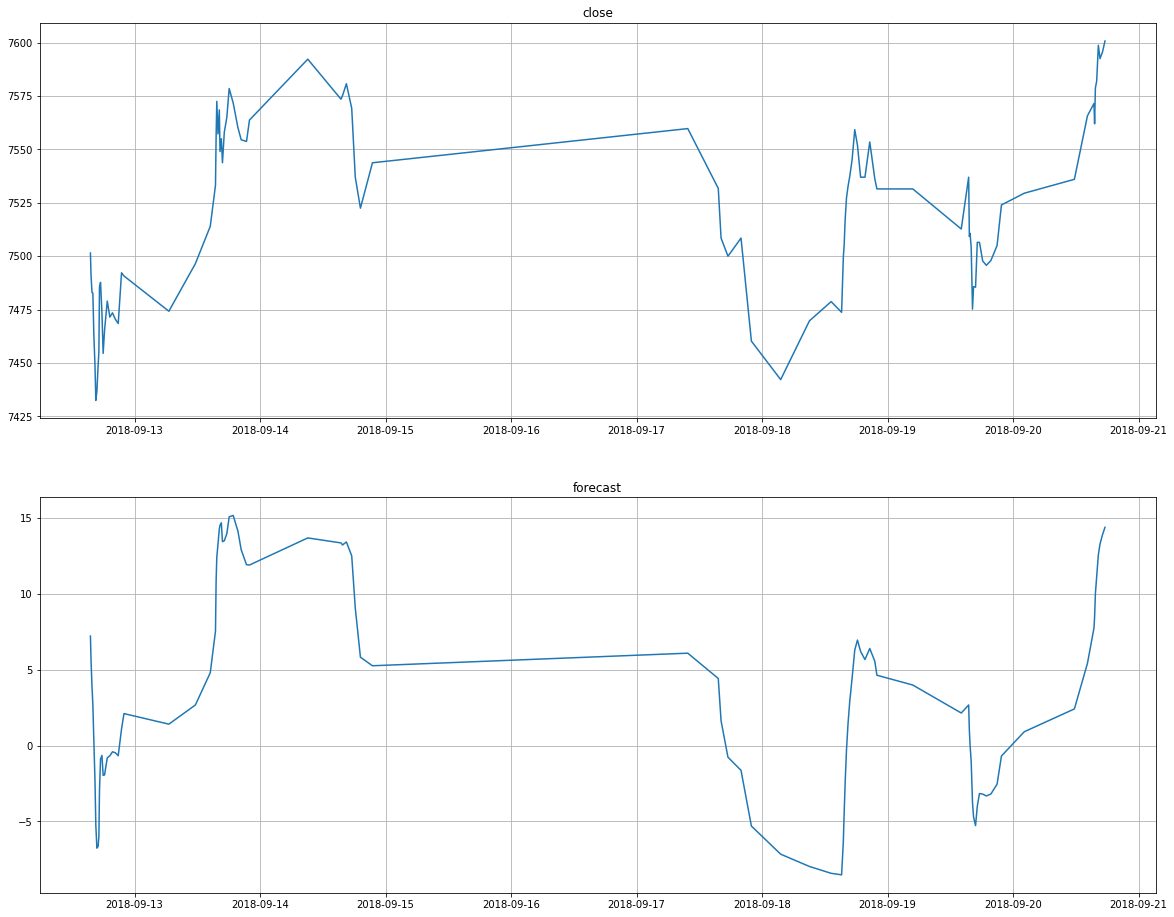

In [14]:
plot(data[['close', 'forecast']].iloc[:100])

In [15]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.120697,-0.00215724,0.0208486,0.0373124,0.0799833,-0.0152334,0.00078443,-0.0353775,-0.0411345
Cumulative returns,0.123233,-0.0022,0.0212667,0.0380667,0.0816333,-0.0155333,0.0008,-0.0360667,-0.0419333
Annual volatility,0.178079,0.166826,0.161207,0.151079,0.136914,0.127128,0.0909768,0.0697804,0.0557775
Sharpe ratio,0.728712,0.0699991,0.208175,0.31752,0.630012,-0.0576481,0.053716,-0.481562,-0.72537
Calmar ratio,0.824326,-0.0220324,0.170174,0.428553,0.822229,-0.12541,0.0151844,-0.394202,-0.395587
Stability,0.806265,0.581923,0.479837,0.502545,0.358876,0.213471,0.195819,0.32204,0.441607
Max drawdown,-0.146419,-0.0979125,-0.122514,-0.087066,-0.0972762,-0.121469,-0.0516602,-0.0897446,-0.103983
Omega ratio,1.13345,1.01194,1.03659,1.05554,1.11592,0.988999,1.01356,0.870566,0.775196
Sortino ratio,1.07043,0.103004,0.309626,0.493163,1.01716,-0.0891144,0.0896108,-0.780285,-1.14569
Skew,-0.00807478,0.274435,0.235055,0.462582,0.642346,0.690465,1.27581,1.89953,2.28608


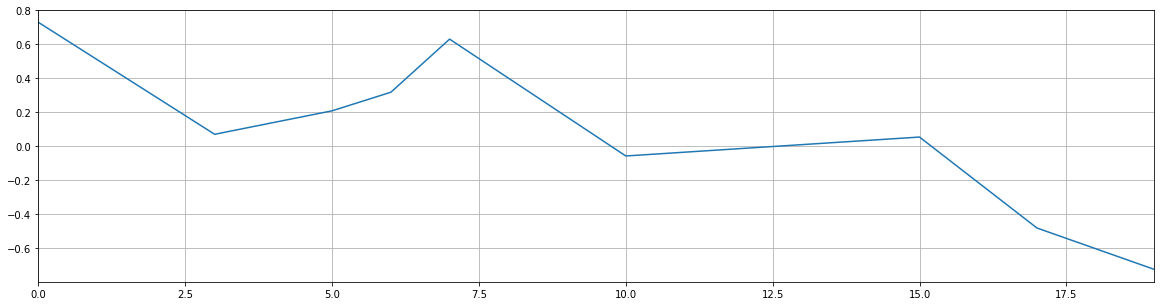

In [16]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [17]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.902079,0.863179,0.811119,0.790783,0.669751,0.426502,0.331893,0.278356
3,0.902079,1.000000,0.932470,0.885637,0.867222,0.732951,0.498320,0.407275,0.335883
5,0.863179,0.932470,1.000000,0.950697,0.918834,0.779821,0.528407,0.431285,0.350426
6,0.811119,0.885637,0.950697,1.000000,0.958990,0.828199,0.542012,0.442097,0.336252
7,0.790783,0.867222,0.918834,0.958990,1.000000,0.858316,0.575046,0.472353,0.347277
10,0.669751,0.732951,0.779821,0.828199,0.858316,1.000000,0.656702,0.554242,0.390509
15,0.426502,0.498320,0.528407,0.542012,0.575046,0.656702,1.000000,0.852044,0.612801
17,0.331893,0.407275,0.431285,0.442097,0.472353,0.554242,0.852044,1.000000,0.724869
19,0.278356,0.335883,0.350426,0.336252,0.347277,0.390509,0.612801,0.724869,1.000000


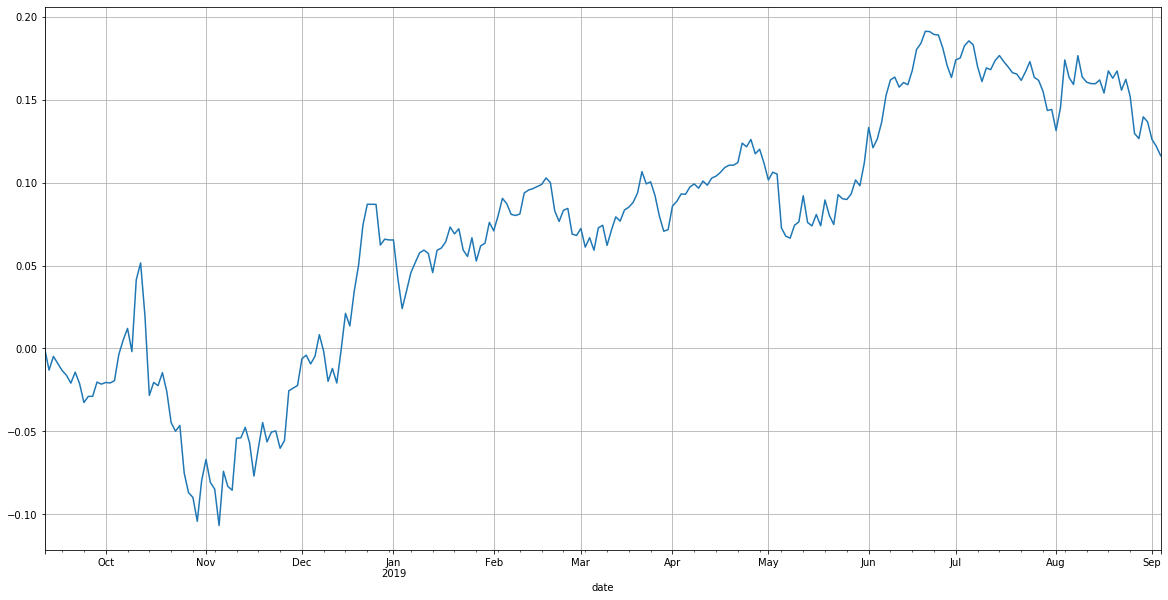

In [18]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

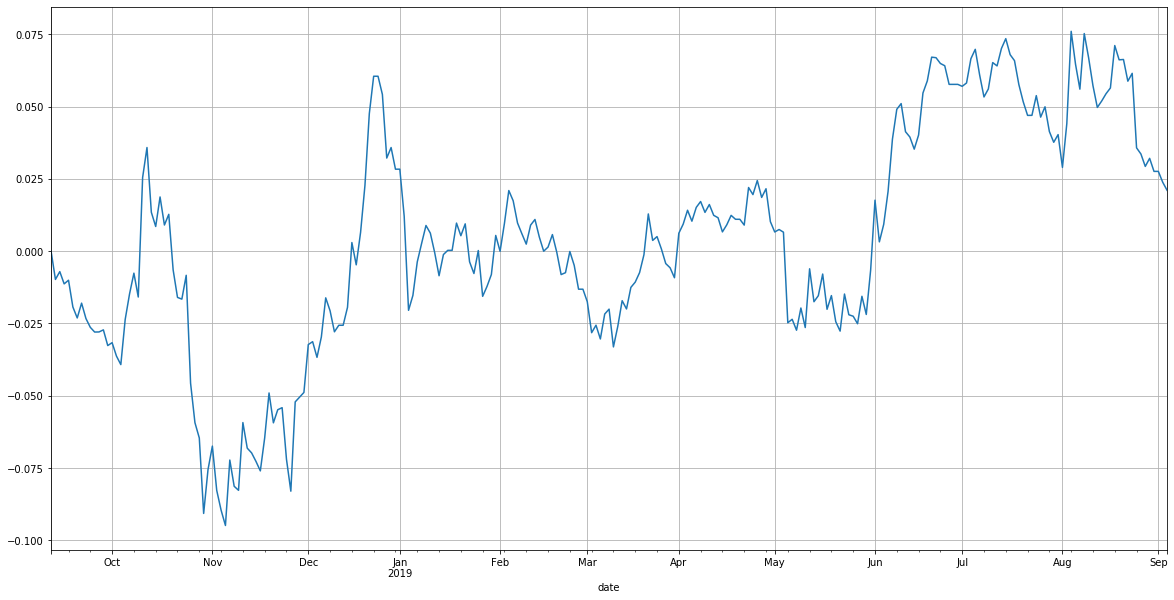

In [19]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

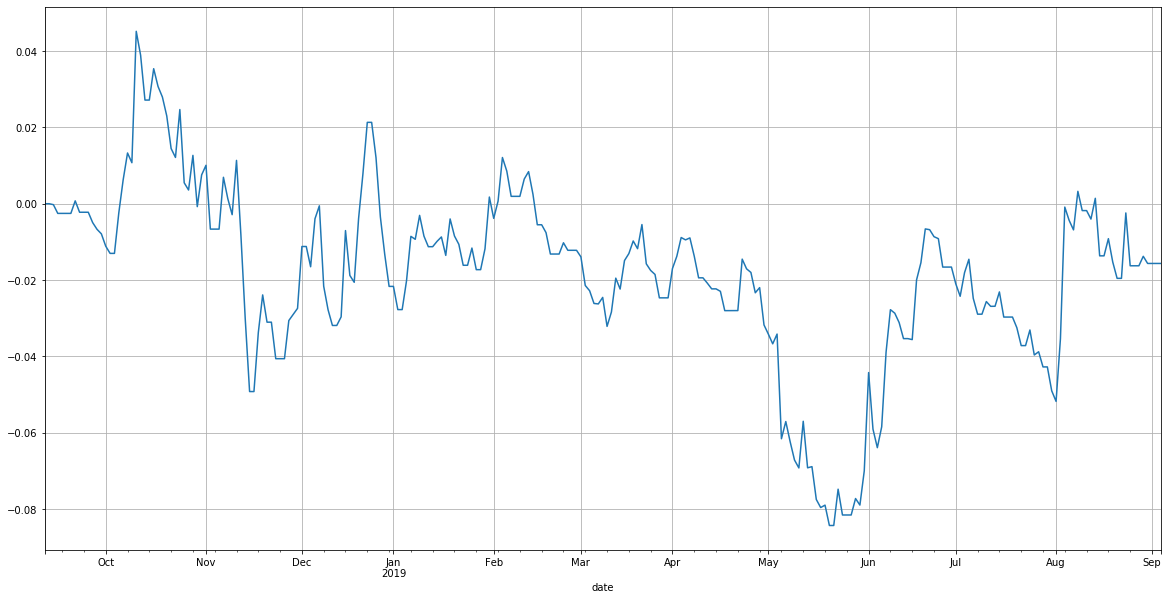

In [20]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);